NOTICE:liionpack.logger:Circuit created
NOTICE:liionpack.logger:Parameter: Current function [A] has been set to input
CasADi - 2023-04-12 23:58:43 WARNING("The options 't0', 'tf', 'grid' and 'output_t0' have been deprecated. Set the time grid by proving additional argument to the 'integrator' call instead.") [.../casadi/core/integrator.cpp:495]
CasADi - 2023-04-12 23:58:43 WARNING("The options 't0', 'tf', 'grid' and 'output_t0' have been deprecated. Set the time grid by proving additional argument to the 'integrator' call instead.") [.../casadi/core/integrator.cpp:495]


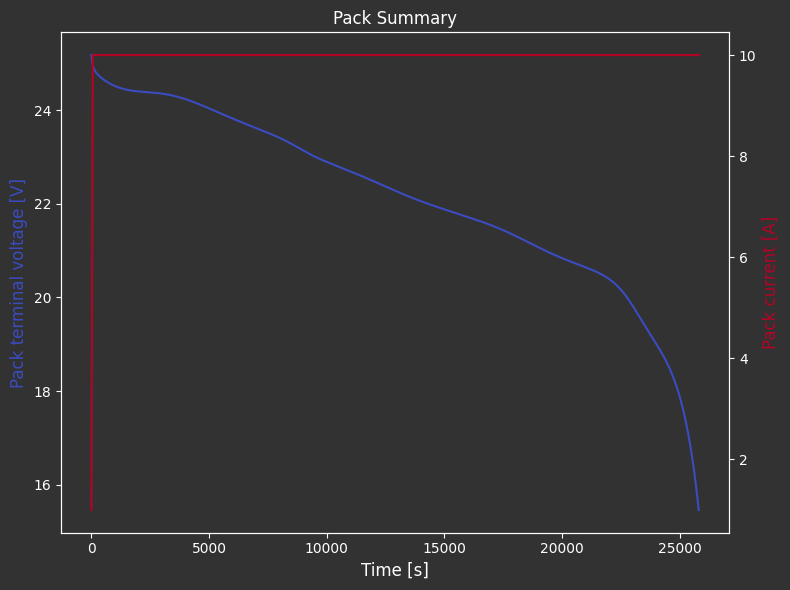

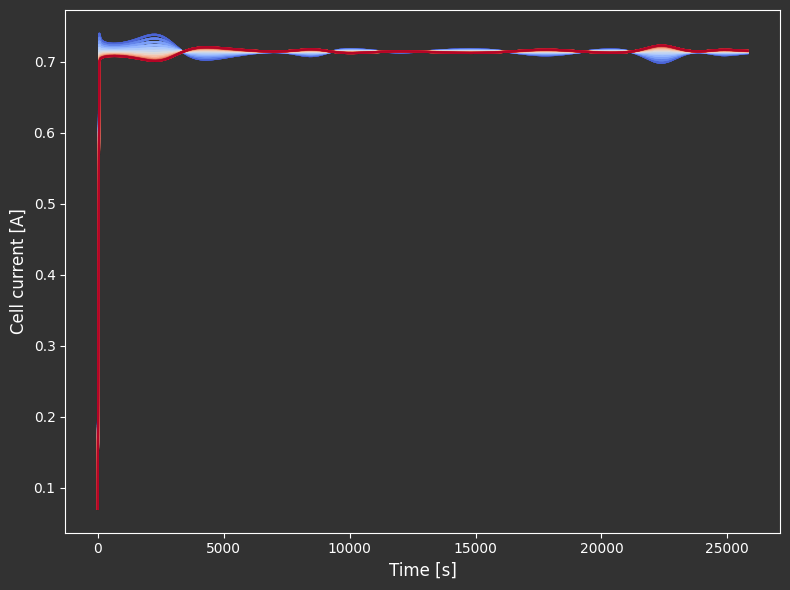

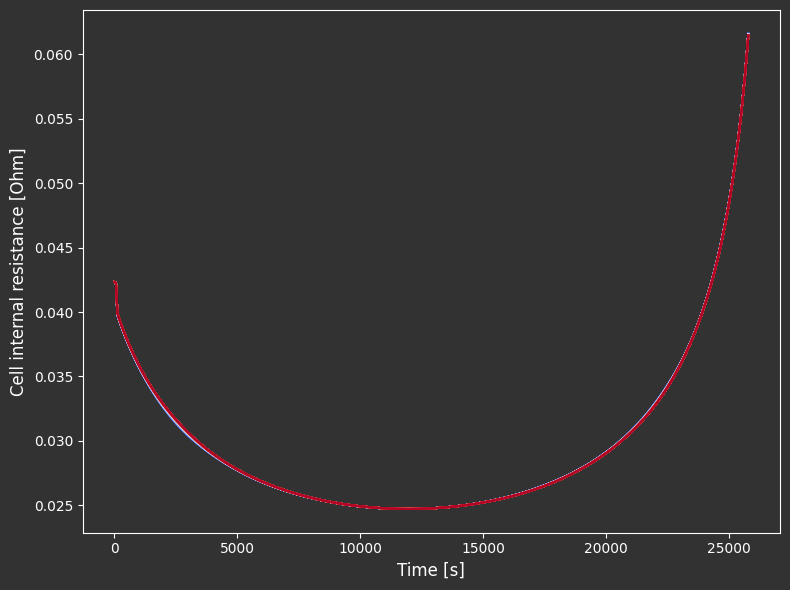

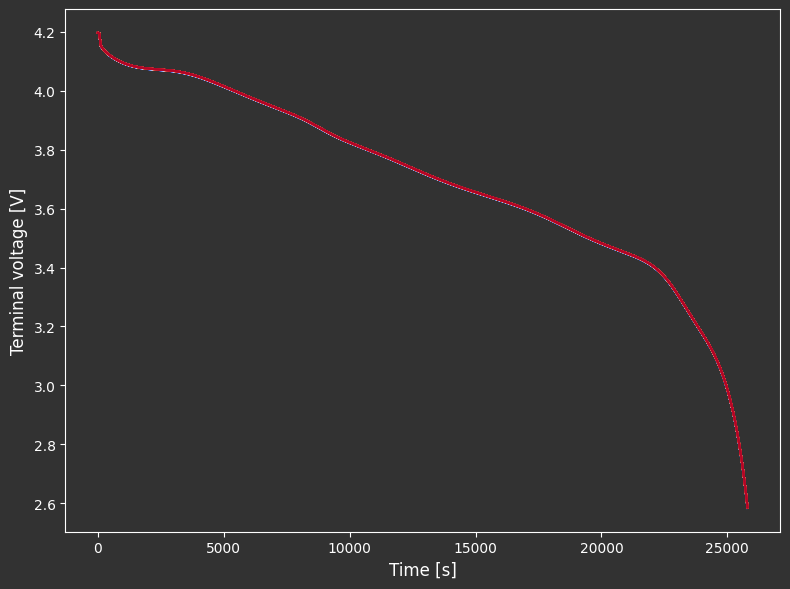

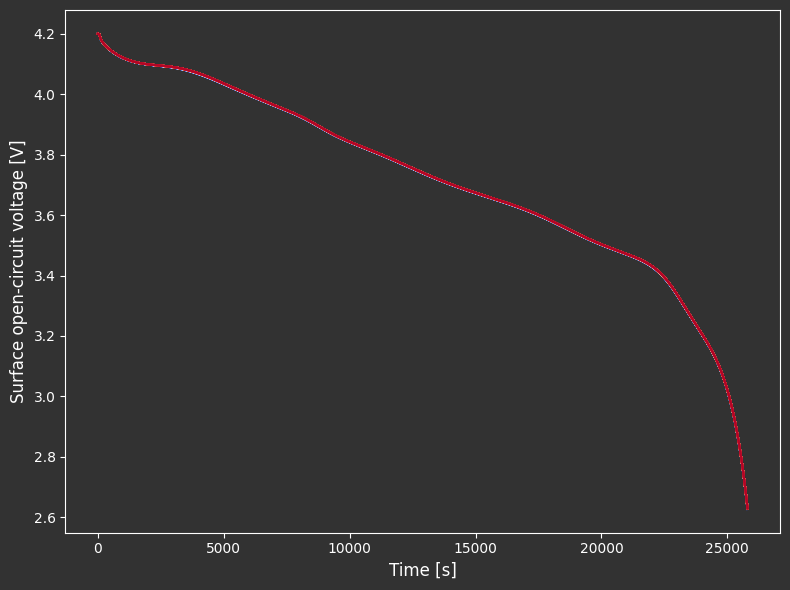

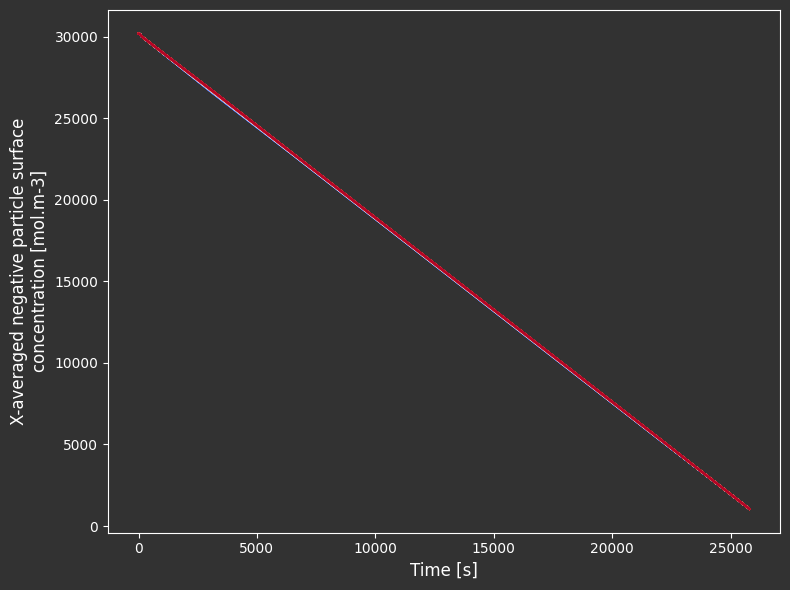

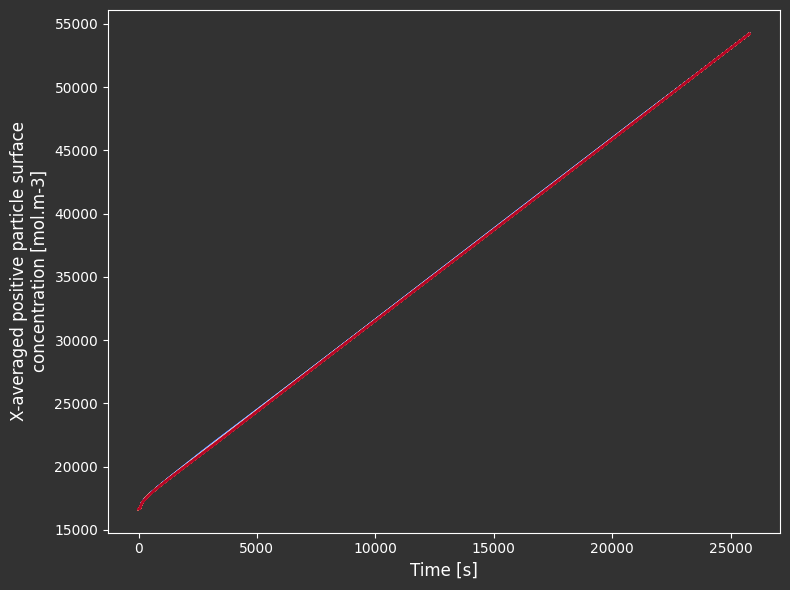

In [18]:
from solar_car_battery_manager import SolarCarBatteryManager

import liionpack as lp
import pybamm
import os
import logging
import time

parameter_values = pybamm.ParameterValues("Chen2020")


class Battery:
    """
    The battery class is the battery of the solar car. It contains the battery model and the battery manager. It modifies PyBaMM and liionpack to work on a step by step basis.

    Parameters
    ----------
    timeStep : float, optional
        The time step length of the simulation in seconds. The default is 1.0.
    """

    # Need accurate numbers for this. Let's just assume Telsa for now?
    Np = 14  # number of parallel cells
    Ns = 6  # number of series cells
    netlist = lp.setup_circuit(
        Np, Ns, V=25, I=300)

    currentDraw = 0
    _step = 1

    def __init__(self, timeStep: float):
        self.timeStep = timeStep

        logging.info("Initializing battery simulation")
        start = time.time()

        outputVariables = [
            "X-averaged negative particle surface concentration [mol.m-3]",
            "X-averaged positive particle surface concentration [mol.m-3]",
        ]
        self.sim = SolarCarBatteryManager()
        self.sim.solve(
            netlist=self.netlist,
            sim_func=lp.basic_simulation,
            parameter_values=parameter_values,
            output_variables=outputVariables,
            inputs=None,
            initial_soc=1,
            nproc=os.cpu_count(),
            dt=self.timeStep,
            setup_only=True,
        )
        # the first two steps are to prevent division by zero errors caused by the first two steps being 0
        logging.info("Battery setup complete")
        self.sim._step(0, None)
        self.sim.step = 0
        self.fullChargeVoltage = self.getVoltage()
        end = time.time()
        logging.info(f'Battery initialized in {end - start} seconds')

    def setDraw(self, current: float):
        self.currentDraw = current

    def step(self):
        start = time.time()
        self.sim.protocol[self._step] = self.currentDraw
        ok = self.sim._step(self._step, None)
        if not ok:
            raise RuntimeError("Battery failed")
        self.sim.step = self._step
        self._step += 1
        end = time.time()
        logging.debug(f'Battery step complete in {end - start} seconds')

    def _output(self):
        return self.sim.step_output()

    def getSoC(self):
        output = self._output()
        neg = output["X-averaged negative particle surface concentration [mol.m-3]"][-1]
        pos = output["X-averaged positive particle surface concentration [mol.m-3]"][-1]
        return {
            "X-averaged negative particle surface concentration [mol.m-3]": neg,
            "X-averaged positive particle surface concentration [mol.m-3]": pos,
        }

    def getVoltage(self):
        return self._output()["Pack terminal voltage [V]"][-1] * self.Np

    def getCellVoltage(self):
        return self._output()["Pack terminal voltage [V]"][-1]



battery = Battery(60)
battery.setDraw(10)
for i in range(430):
    battery.step()
output = battery._output()

lp.plot_output(output)

In [2]:
#
# A basic example of a pack simulation with varying external temperature.
#

import liionpack as lp
import pybamm
import numpy as np
import time as ticker
from tqdm import tqdm


lp.set_logging_level("NOTICE")

# Define parameters
Np = 16
Ns = 2
Nspm = Np * Ns
Iapp = 20

# Generate the netlist
netlist = lp.setup_circuit(Np=Np, Ns=Ns)

# Define additional output variables
output_variables = ["Volume-averaged cell temperature [K]"]

# Define a cycling experiment using PyBaMM
experiment = pybamm.Experiment(
    [
        f"Charge at {Iapp} A for 30 minutes",
        "Rest for 15 minutes",
        f"Discharge at {Iapp} A for 30 minutes",
        "Rest for 30 minutes",
    ],
    period="10 seconds",
)

# Define the PyBaMM parameters
parameter_values = pybamm.ParameterValues("Chen2020")
T0 = parameter_values["Initial temperature [K]"]

inputs = {}
input_temperature = np.ones(Nspm) * T0
inputs.update({"Input temperature [K]": input_temperature})
# Solve the pack

rm = lp.CasadiManager()
rm.solve(
    netlist=netlist,
    sim_func=lp.thermal_external,
    parameter_values=parameter_values,
    experiment=experiment,
    output_variables=output_variables,
    inputs=inputs,
    nproc=2,
    initial_soc=0.5,
    setup_only=True,
)


def external_stepper(manager, T0):
    tic = ticker.time()
    # Do stepping
    lp.logger.notice("Starting step solve")
    vlims_ok = True
    input_temperature = np.ones(Nspm) * T0
    with tqdm(total=manager.Nsteps, desc="Stepping simulation") as pbar:
        step = 0
        while step < manager.Nsteps and vlims_ok:
            input_temperature += 0.1
            inputs.update({"Input temperature [K]": input_temperature})
            vlims_ok = manager._step(step, inputs)
            step += 1
            pbar.update(1)
    manager.step = step
    toc = ticker.time()
    lp.logger.notice("Step solve finished")
    lp.logger.notice("Total stepping time " + str(np.around(toc - tic, 3)) + "s")
    lp.logger.notice(
        "Time per step " + str(np.around((toc - tic) / manager.Nsteps, 3)) + "s"
    )


external_stepper(rm, T0)
output = rm.step_output()
# Plot the pack and individual cell results
lp.plot_pack(output)
lp.plot_cells(output)
lp.show_plots()

CasADi - 2023-04-12 20:59:16 WARNING("The options 't0', 'tf', 'grid' and 'output_t0' have been deprecated. Set the time grid by proving additional argument to the 'integrator' call instead.") [.../casadi/core/integrator.cpp:495]
CasADi - 2023-04-12 20:59:16 WARNING("The options 't0', 'tf', 'grid' and 'output_t0' have been deprecated. Set the time grid by proving additional argument to the 'integrator' call instead.") [.../casadi/core/integrator.cpp:495]


KeyError: "'Discharge Capacity [A.h]' not found. Best matches are ['Discharge capacity [A.h]', 'Discharge energy [W.h]', 'Throughput capacity [A.h]']"